# Hardware and Computational Capabilities

In [2]:
print()
print()

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')



Your runtime has 8.5 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


# Importing the libraries

In [3]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

from sklearn.manifold import TSNE

#from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

import pickle
import tarfile
import wget

# Set the seed for reproducibility and create useful folders

In [6]:
def set_seed(seed = 16):
    np.random.seed(16)
    torch.manual_seed(16)

set_seed()

# create a folder called saved_models if it does not exist
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    print('saved_models folder created')
else:
    print('saved_models folder already exists')

# create a folder called saved_plots if it does not exist
if not os.path.exists('saved_plots'):
    os.mkdir('saved_plots')
    print('saved_plots folder created')
else:
    print('saved_plots folder already exists')

saved_models folder created
saved_plots folder created


# Load and prepare Cifar100 dataset

In [8]:
from download_cifar100 import load_cifar100

# load cifar-100 data
images, labels, testimages, testlabels = load_cifar100()

Train data loaded!
Train data shape: (50000, 3072) | Train labels shape: (50000,)
Test data loaded!
Test data shape: (10000, 3072) | Test labels shape: (10000,)


In [ ]:
# reshape training images and test images to 32x32x3
images = images.reshape((-1,3,32,32))
images = images.reshape((-1,3,32,32))
# change training images and test images type to float32
images = images.astype(np.float)
testimages = testimages.astype(np.float)
print('Training images and test images reshaped to 32x32x3 and changed to float32')
print('Training images shape: ' + str(images.shape) + ' | Test images shape: ' + str(testimages.shape))

# change training labels and test labels type to int64
labels = labels.astype(np.int)
testlabels = testlabels.astype(np.int)
print('Training labels and test labels changed to int64')

<ipython-input-8-3a08517d080b>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)


Training images and test images reshaped to 32x32x3 and changed to float32
Training images shape: (50000, 3, 32, 32) | Test images shape: (10000, 3072)
Training labels and test labels changed to int64


<ipython-input-8-3a08517d080b>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testimages = testimages.astype(np.float)
<ipython-input-8-3a08517d080b>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.asty

# Data Generator and Data Loader for Cifar10
Let, the training and validation split be 80:20. Without many complications, let us consider the ‘batch-5’ of the CIFAR10 dataset as the validation set and the rest as the training set. 
We also calculate the channel-wise mean and standard deviation of the pixel values on the training split. 
We will use these statistics to normalize the pixel values of the training and validation splits.



In [ ]:
from data_augmentation.C100DataGenerator import C100DataGen

#calculate the channel-wise mean and standard deviation of the pixel values on the training split
MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

#split 80:20 with batch5 as validation set
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]

# create data generator for training images
dg = C100DataGen('train',trimages)#train_df)
# create data loader for training images
dl = DataLoader(dg,batch_size = 128,drop_last=True)

# create data generator for test images
vdg = C100DataGen('valid',valimages)#_df)
# create data loader for test images
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

# Show single batch of double images from the data augmantation of SimCLR

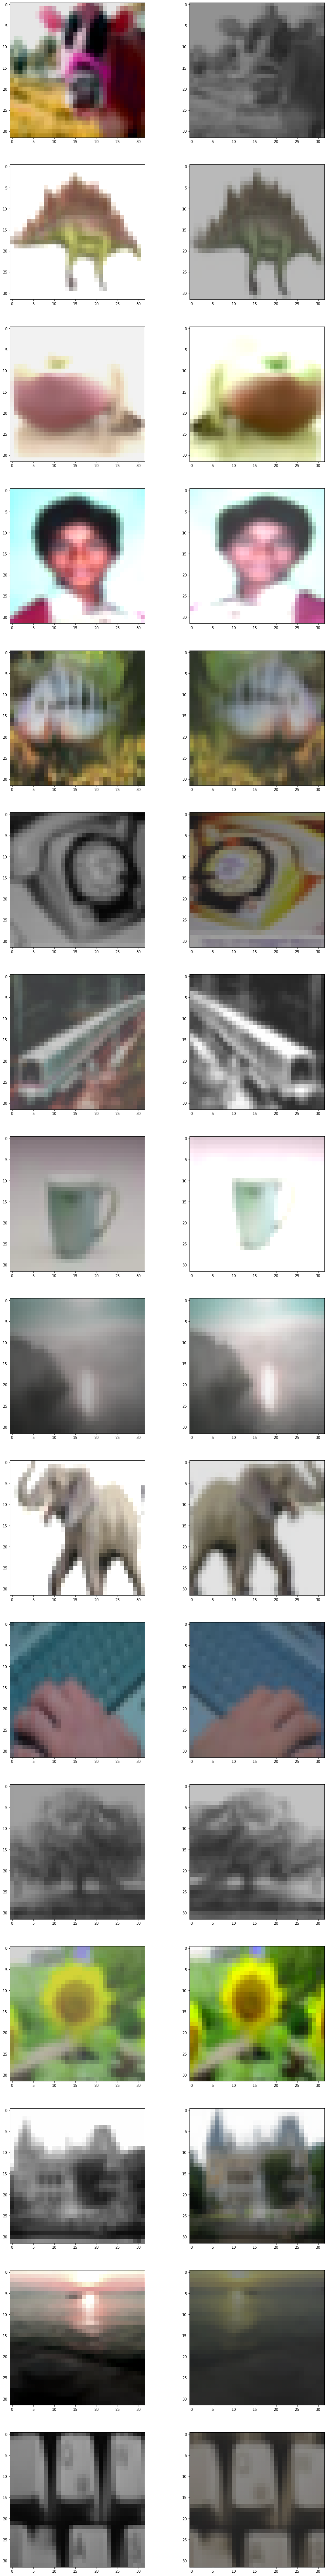

In [ ]:
fig,axs = plt.subplots(16,2,figsize=(16,128))
row = 0
col = 0
for step,(x1,x2) in enumerate(dl):
    
    for i in range(16):
        #print(x1[i]*STD + MEAN)
        #print(x2[i]*STD + MEAN)
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

# Load Model, Loss Function, Optimizer and Scheduler

In [ ]:
from models.resnet_simclr import PreModel

# define the device to use and print it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(str(device) + " will be used.")

# define the model and move it to the device
model = PreModel('resnet50','avgpool').to(device)

from models.loss import SimCLR_Loss

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

from models.optimizer import LARS

#OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"

#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

cuda:0 will be used.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


# Training Loop

Epoch [1/20]	


/content/drive/.shortcut-targets-by-id/1J8LiaBurdqWPie7tRICpEMBtOAEETYFD/test_repo_Cifar100/models/optimizer.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  next_v.mul_(momentum).add_(scaled_lr, grad)


Step [0/312]	 Loss: 5.17624
Step [50/312]	 Loss: 4.35518
Step [100/312]	 Loss: 4.06594
Step [150/312]	 Loss: 3.90402
Step [200/312]	 Loss: 3.85835
Step [250/312]	 Loss: 3.81526
Step [300/312]	 Loss: 3.80047
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/78]	 Loss: 3.67571
Step [50/78]	 Loss: 3.6658
Epoch [1/20]	 Training Loss: 4.04907899025159	 lr: 0.04
Epoch [1/20]	 Validation Loss: 3.671463098281469	 lr: 0.04
Epoch [1/20]	 Time Taken: 6.859087451299032 minutes
Epoch [2/20]	
Step [0/312]	 Loss: 3.77656
Step [50/312]	 Loss: 3.75404
Step [100/312]	 Loss: 3.7516
Step [150/312]	 Loss: 3.76023
Step [200/312]	 Loss: 3.75728
Step [250/312]	 Loss: 3.7467
Step [300/312]	 Loss: 3.74896
Adjusting learning rate of group 0 to 6.0000e-02.
Model Saved at checkpoint epoch n2
Loss Saved at checkpoint epoch n2
Step [0/78]	 Loss: 3.65728
Step [50/78]	 Loss: 3.64729
Epoch [2/20]	 Training Loss: 3.758759147845782	 lr: 0.06
Epoch [2/20]	 Validation Loss: 3.6512860304270034	 lr: 0.06
Epoch [2/20]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


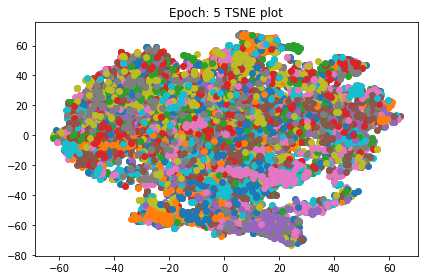

Epoch [6/20]	
Step [0/312]	 Loss: 3.70352
Step [50/312]	 Loss: 3.6921
Step [100/312]	 Loss: 3.70607
Step [150/312]	 Loss: 3.70207
Step [200/312]	 Loss: 3.70402
Step [250/312]	 Loss: 3.68891
Step [300/312]	 Loss: 3.6861
Adjusting learning rate of group 0 to 1.4000e-01.
Model Saved at checkpoint epoch n6
Loss Saved at checkpoint epoch n6
Step [0/78]	 Loss: 3.6217
Step [50/78]	 Loss: 3.62543
Epoch [6/20]	 Training Loss: 3.6976834527957134	 lr: 0.14
Epoch [6/20]	 Validation Loss: 3.621599628375127	 lr: 0.14
Epoch [6/20]	 Time Taken: 6.79054681857427 minutes
Epoch [7/20]	
Step [0/312]	 Loss: 3.69467
Step [50/312]	 Loss: 3.68763
Step [100/312]	 Loss: 3.6998
Step [150/312]	 Loss: 3.67712
Step [200/312]	 Loss: 3.69362
Step [250/312]	 Loss: 3.6869
Step [300/312]	 Loss: 3.69978
Adjusting learning rate of group 0 to 1.6000e-01.
Step [0/78]	 Loss: 3.62323
Step [50/78]	 Loss: 3.62019
Epoch [7/20]	 Training Loss: 3.688895808580594	 lr: 0.16
Epoch [7/20]	 Validation Loss: 3.618804176648458	 lr: 0.16


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


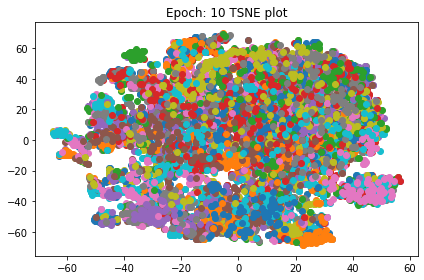

Epoch [11/20]	
Step [0/312]	 Loss: 3.66444
Step [50/312]	 Loss: 3.65385
Step [100/312]	 Loss: 3.65731
Step [150/312]	 Loss: 3.65174
Step [200/312]	 Loss: 3.66763
Step [250/312]	 Loss: 3.66214
Step [300/312]	 Loss: 3.66305
Epoch 00002: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/78]	 Loss: 3.61184
Step [50/78]	 Loss: 3.61089
Epoch [11/20]	 Training Loss: 3.6647850435513716	 lr: 0.19999
Epoch [11/20]	 Validation Loss: 3.6093382835388184	 lr: 0.19999
Epoch [11/20]	 Time Taken: 6.6788879116376245 minutes
Epoch [12/20]	
Step [0/312]	 Loss: 3.65775
Step [50/312]	 Loss: 3.65097
Step [100/312]	 Loss: 3.65243
Step [150/312]	 Loss: 3.66084
Step [200/312]	 Loss: 3.65227
Step [250/312]	 Loss: 3.65879
Step [300/312]	 Loss: 3.67474
Epoch 00003: adjusting learning rate of group 0 to 1.9999e-01.
Model Saved at checkpoint epoch n12
Loss Saved at checkpoint epoch n12
Step [0/78]	 Loss: 3.61334
Step [50/78]	 Loss: 3.61206
Epoch [12/20]	 Training Loss: 3.65994494389265	 lr: 0.19999
Epoch [12

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


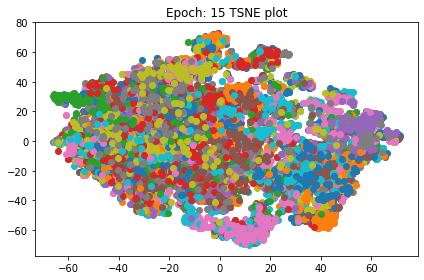

Epoch [16/20]	
Step [0/312]	 Loss: 3.65037
Step [50/312]	 Loss: 3.64254
Step [100/312]	 Loss: 3.65548
Step [150/312]	 Loss: 3.65228
Step [200/312]	 Loss: 3.6501
Step [250/312]	 Loss: 3.64041
Step [300/312]	 Loss: 3.65274
Epoch 00007: adjusting learning rate of group 0 to 1.9993e-01.
Model Saved at checkpoint epoch n16
Loss Saved at checkpoint epoch n16
Step [0/78]	 Loss: 3.60705
Step [50/78]	 Loss: 3.60393
Epoch [16/20]	 Training Loss: 3.6481428620142813	 lr: 0.19993
Epoch [16/20]	 Validation Loss: 3.605568604591565	 lr: 0.19993
Epoch [16/20]	 Time Taken: 6.731845990816752 minutes
Epoch [17/20]	
Step [0/312]	 Loss: 3.64918
Step [50/312]	 Loss: 3.64966
Step [100/312]	 Loss: 3.63955
Step [150/312]	 Loss: 3.66054
Step [200/312]	 Loss: 3.64938
Step [250/312]	 Loss: 3.64918
Step [300/312]	 Loss: 3.65012
Epoch 00008: adjusting learning rate of group 0 to 1.9991e-01.
Step [0/78]	 Loss: 3.60371
Step [50/78]	 Loss: 3.60704
Epoch [17/20]	 Training Loss: 3.6451610777622614	 lr: 0.19991
Epoch [17/

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


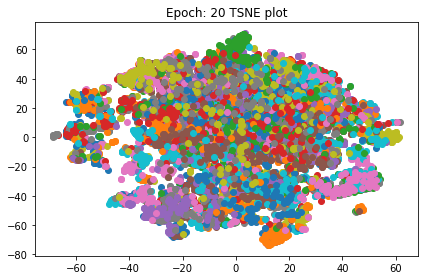

Training Finished!
Model Saved!
Losses Saved!


In [ ]:
from models.training import train, valid
from models.TSNE import plot_features
from utils import save_model, save_loss, save_loss_checkpoint

nr = 0
global_step = 0
current_epoch = 1
epochs = 20

tr_loss = []
val_loss = []

for epoch in range(1, epochs+1):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dl, model, criterion, optimizer, nr)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and current_epoch % 2 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR100_RN50__checkpoint_Epoch_n" + str(current_epoch) +"pt")
        print('Model Saved at checkpoint epoch n'+ str(current_epoch))
        save_loss_checkpoint(tr_loss, val_loss, current_epoch)
        print('Loss Saved at checkpoint epoch n'+ str(current_epoch))

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion, nr)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dl))
        
        val_loss.append(val_loss_epoch / len(vdl))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")
    
    if epoch % 5 == 0 :
        plot_features(model.pretrained, 100, 2048, 128, vdl, valimages, vallabels, epoch)

    # if (epoch+1)%10==0:
    #     plot_features(model.pretrained, 10, 2048, 128, vdl, valimages, vallabels, epoch+1)

## end training
print('Training Finished!')
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR100_RN50_END_TRAINING_Epoch_n" + str(epochs) +"pt")
print('Model Saved!')
save_loss(tr_loss, val_loss)
print('Losses Saved!')

# Plot the training and validation loss

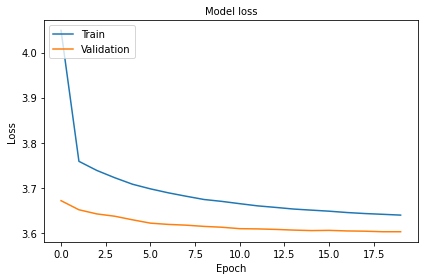

In [ ]:
from utils import plot_loss

plot_loss(tr_loss, val_loss)